# Memory and Timing Requirements

Notebook to keep track of how long runs roughly take and memory requirements. Important for job sizing.

In [2]:
# Standard Imports

import numpy as np
import scipy.integrate
import time as tm
from tqdm.notebook import tqdm 
import xarray as xr
import sys
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from ginelli96 import Ginelli96

## Some Notes

Currently have jobs running so you can have more certain timing estimates. 02/04/2020 16:37

## Timings

### Transient

How long do transient steps take

In [3]:
tr_data = [xr.open_dataset(f'L96_transient{tr}_00.nc') for tr in [10, 100, 1000, 10000]]

In [4]:
trtimings = [data.attrs['transient'] for data in tr_data] # Length of Steps involving k_b

In [3]:
# Quick line fit to estimate k_a time in hours

def tr_sizer(tr):
    slope = (tr_data[-1].attrs['Transient (s)'] - tr_data[0].attrs['Transient (s)'])/(tr_data[-1].attrs['transient'] 
                                                                                      - tr_data[0].attrs['transient'])
    c = tr_data[0].attrs['Transient (s)']
    return (slope * (tr - tr_data[0].attrs['transient']) + c)/3600 
tr_sizer(1000) 

NameError: name 'tr_data' is not defined

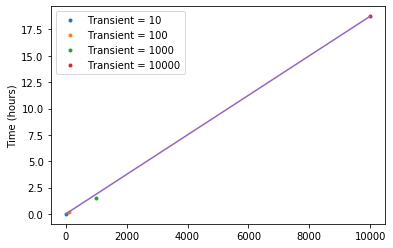

In [10]:
for data in tr_data: plt.plot(data.attrs['transient'], data.attrs['Transient (s)']/3600, '.', label = 'Transient = ' + str(data.attrs['transient'])) 
plt.legend()
plt.ylabel('Time (hours)')
estimate = [tr_sizer(x) for x in np.linspace(0, 10000, 100)]
plt.plot(np.linspace(0, 10000, 100), estimate)

### Effect of $k_A$

How long for BLV convergence

In [11]:
ka_data = [xr.open_dataset(f'L96_kA{ka}_00.nc') for ka in [10, 100, 1000, 10000]]

In [12]:
katimings = [data.attrs['Step 1'] for data in ka_data] # Length of Steps involving k_b

In [14]:
# Quick line fit to estimate k_a time in hours

def ka_sizer(kA):
    slope = (ka_data[-1].attrs['Step 1'] - ka_data[0].attrs['Step 1'])/(ka_data[-1].attrs['kA'] - ka_data[0].attrs['kA'])
    c = ka_data[0].attrs['Step 1']
    return (slope * (kA - ka_data[0].attrs['kA']) + c)/3600

ka_sizer(1000)

1.9266389009938225

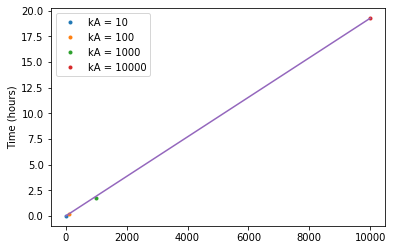

In [15]:
for data in ka_data: plt.plot(data.attrs['kA'], data.attrs['Step 1']/3600, '.', label = 'kA = ' + str(data.attrs['kA'])) 
plt.legend()
plt.ylabel('Time (hours)')
estimate = [ka_sizer(x) for x in np.linspace(0, 10000, 100)]
plt.plot(np.linspace(0, 10000, 100), estimate)

### Effect of $k_B$

Here we look at how the number of samples effect the run length.

In [17]:
directory = 'Data'
data1500= xr.open_dataset(directory + '/L96_Ginelli_kB1500_00.nc')
data2000= xr.open_dataset(directory + '/L96_Ginelli_kB2000_00.nc')
data2500= xr.open_dataset(directory + '/L96_Ginelli_kB2500_00.nc')
data3000= xr.open_dataset(directory + '/L96_Ginelli_kB3000_00.nc')
kb_data = [data1500, data2000, data2500, data3000]

In [18]:
kbtimings = [data.attrs['Step 2'] + data.attrs['Step 5'] for data in kb_data] # Length of Steps involving k_b

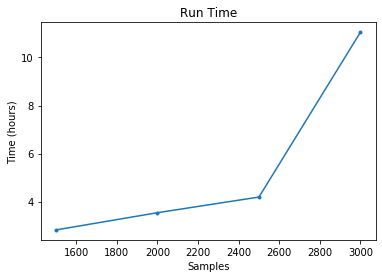

In [21]:
plt.plot([data.attrs['kB'] for data in kb_data], np.array(kbtimings)/3600, '.-')
plt.xlabel('Samples')
plt.ylabel('Time (hours)')
plt.title('Run Time')
plt.show()
#plt.savefig('Timings', dpi=1200)

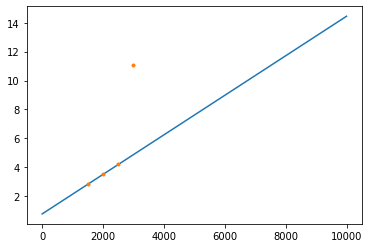

In [38]:
# Quick line fit to estimate k_b time

def kb_sizer(kb):
    slope = (kbtimings[-2] - kbtimings[0])/(kb_data[-2].attrs['kB'] - kb_data[0].attrs['kB']) # In seconds
    y = slope * (kb - kb_data[0].attrs['kB']) + kbtimings[0]
    return(y/3600) # Hours
    
x_d = np.linspace(0, int(1.e4), 1000)
plt.plot(x_d, [kb_sizer(x) for x in x_d])
plt.plot([data.attrs['kB'] for data in kb_data], np.array(kbtimings)/3600, '.', label = 'Data points')

### Effect of $k_C$

Here we look at how the number of CLV Convergence Steps effect the run length.

In [113]:
data300= xr.open_dataset(directory + '/L96_Ginelli_kc300_00.nc')
data500= xr.open_dataset(directory + '/L96_Ginelli_kc500_00.nc')
data700= xr.open_dataset(directory + '/L96_Ginelli_kc700_00.nc')
data900= xr.open_dataset(directory + '/L96_Ginelli_kc900_00.nc')
kc_data = [data300, data500, data700, data900]

In [114]:
timings = [data.attrs['Step 3'] + data.attrs['Step 4'] for data in kc_data] # Length of Steps involving k_C

In [118]:
# Quick line fit to estimate k_c time

slope = (timings[-1] - timings[1])/400

def kc_sizer(kc):
    slope = (timings[-1] - timings[1])/400 # In seconds
    y = slope * (kc - 500) + timings[1]
    print(f'For kc = {kc} we will need about {y/3600} hours')
    
kc_sizer(5000)

For kc = 5000 we will need about 13.395156322883235 hours


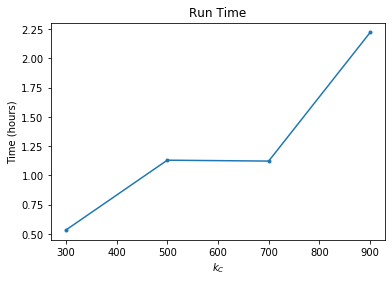

In [70]:
plt.plot(range(300, 1100, 200), np.array(timings)/3600, '.-')
plt.xlabel('$k_C$')
plt.ylabel('Time (hours)')
plt.title('Run Time')
plt.show()